In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import gaussian_kde

class PolymerMotion:
    def __init__(self, num_particles, spring_constants, mass=1.0, dt=0.01, total_time=10):
        self.num_particles = num_particles
        self.spring_constants = spring_constants
        self.mass = np.full(num_particles, mass)  # Mass for each particle
        self.dt = dt
        self.total_time = total_time

        # Initialize positions and velocities
        self.positions = np.random.rand(num_particles, 2)  # Random initial positions in 2D
        self.velocities = np.zeros((num_particles, 2))  # Start with zero velocity
        self.time_steps = int(total_time / dt)  # Total number of time steps
        self.trajectory = np.zeros((self.time_steps, num_particles, 2))  # Store trajectory

    def forces(self, positions):
        # Calculate the spring forces
        F = np.zeros((self.num_particles, 2))
        for i in range(self.num_particles):
            for j in range(i + 1, self.num_particles):
                # Calculate the spring force based on Hooke's law
                displacement = positions[j] - positions[i]
                distance = np.linalg.norm(displacement)
                if distance > 0:
                    spring_force = self.spring_constants[i] * displacement / distance
                    F[i] += spring_force
                    F[j] -= spring_force  # Action-Reaction pair
        return F

    def motion_equations(self, y, t):
        # Unpack positions and velocities from the state vector y
        positions = y[:self.num_particles * 2].reshape((self.num_particles, 2))
        velocities = y[self.num_particles * 2:].reshape((self.num_particles, 2))

        # Calculate forces
        F = self.forces(positions)

        # Add damping force (assumed uniform damping coefficient)
        damping_coefficient = 0.1  # Adjust this value as needed
        damping_force = -damping_coefficient * velocities

        # Equations of motion: d(position)/dt = velocity, d(velocity)/dt = (force + damping) / mass
        dydt = np.zeros_like(y)
        dydt[:self.num_particles * 2] = velocities.flatten()  # d(position)/dt = velocity
        dydt[self.num_particles * 2:] = ((F + damping_force) / self.mass[:, None]).flatten()  # d(velocity)/dt = (force + damping) / mass

        return dydt

    def simulate(self):
        # Initial state vector: [positions, velocities]
        initial_conditions = np.hstack((self.positions.flatten(), self.velocities.flatten()))
        t = np.linspace(0, self.total_time, self.time_steps)

        # Integrate the equations of motion
        solution = odeint(self.motion_equations, initial_conditions, t)

        # Extract positions from the solution
        positions = solution[:, :self.num_particles * 2].reshape((-1, self.num_particles, 2))
        self.trajectory = positions  # Store the trajectory
        return t, positions

    def generate_transition_matrix(self):
        # Create a transition matrix based on the entire trajectory
        transition_matrix = np.zeros((self.num_particles, self.num_particles))

        # Calculate cumulative displacement over the trajectory
        cumulative_displacements = np.zeros((self.num_particles, self.num_particles))
        for t in range(1, self.time_steps):
            for i in range(self.num_particles):
                for j in range(self.num_particles):
                    if i != j:
                        displacement = np.linalg.norm(self.trajectory[t, i] - self.trajectory[t, j])
                        cumulative_displacements[i, j] += displacement

        # Use cumulative displacement to adjust transition probabilities (closer -> higher probability)
        for i in range(self.num_particles):
            row_sum = cumulative_displacements[i].sum()
            if row_sum == 0:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles
            else:
                for j in range(self.num_particles):
                    if i != j and cumulative_displacements[i, j] > 0:
                        transition_matrix[i, j] = 1 / cumulative_displacements[i, j]

        # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(axis=1)
        for i in range(self.num_particles):
            if row_sums[i] > 0:
                transition_matrix[i] /= row_sums[i]
            else:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles

        return transition_matrix

    def sample_random_walk(self, transition_matrix, num_steps, initial_state=0):
        state = initial_state
        visited_states = [state]

        for _ in range(num_steps):
            state = np.random.choice(self.num_particles, p=transition_matrix[state])
            visited_states.append(state)

        return visited_states
    
    def plot_trajectories(self):
        # Plot the trajectories of particles as a function of time
        time = np.linspace(0, self.total_time, self.time_steps)
        plt.figure(figsize=(12, 6))

        for i in range(self.num_particles):
            plt.plot(time, self.trajectory[:, i, 0], label=f'Particle {i+1} X Position', linestyle='-')
            plt.plot(time, self.trajectory[:, i, 1], label=f'Particle {i+1} Y Position', linestyle='--')

        plt.title('Trajectories of Particles Over Time')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_probability_distribution(self, visited_states):
        # Create a histogram of visited states
        plt.figure(figsize=(10, 6))
        plt.hist(visited_states, bins=np.arange(self.num_particles + 1) - 0.5, density=True, alpha=0.6, color='b', edgecolor='black')
        plt.title('Probability Distribution from Random Walk')
        plt.xlabel('Node')
        plt.ylabel('Probability')
        plt.xticks(np.arange(self.num_particles))
        plt.grid()
        plt.xlim(-0.5, self.num_particles - 0.5)  # Set limits to match the bins
        plt.show()

In [21]:
# Parameters
num_nodes = 10
spring_constants = np.random.rand(num_nodes)  # Random spring constants
mass = 1.0
dt = 0.01
total_time = 10  # Total simulation time
num_steps = 1000  # Number of steps for the random walk

# Initialize the PolymerMotion
polymer_motion = PolymerMotion(num_nodes, spring_constants, mass, dt, total_time)

# Simulate the polymer motion
time, positions = polymer_motion.simulate()

# Generate the transition matrix using the last positions
transition_matrix = polymer_motion.generate_transition_matrix()
print("Transition Matrix:\n", transition_matrix)

Transition Matrix:
 [[0.         0.10169145 0.125743   0.10535331 0.16828172 0.06789373
  0.15022361 0.07960878 0.10736027 0.09384414]
 [0.13570146 0.         0.11859967 0.10190552 0.12918015 0.08661247
  0.12819151 0.08098092 0.11559143 0.10323687]
 [0.13582572 0.09600229 0.         0.09098207 0.16418585 0.07171304
  0.15711789 0.07169886 0.1137734  0.09870087]
 [0.13384256 0.09701607 0.1070049  0.         0.14190391 0.07858331
  0.14128812 0.10545344 0.10764693 0.08726077]
 [0.14187836 0.08161593 0.12814944 0.09417324 0.         0.05805318
  0.23371231 0.06205579 0.11248116 0.0878806 ]
 [0.12332864 0.11790022 0.12059637 0.11236176 0.12507805 0.
  0.11518661 0.0856585  0.10548871 0.09440115]
 [0.13105604 0.08380657 0.12689552 0.09702384 0.24183616 0.05532056
  0.         0.06470993 0.10878955 0.09056184]
 [0.12975838 0.09891385 0.10819035 0.13529732 0.11997136 0.07686182
  0.12090008 0.         0.10304813 0.10705872]
 [0.12894074 0.10403324 0.12649959 0.10176588 0.16023123 0.06974584


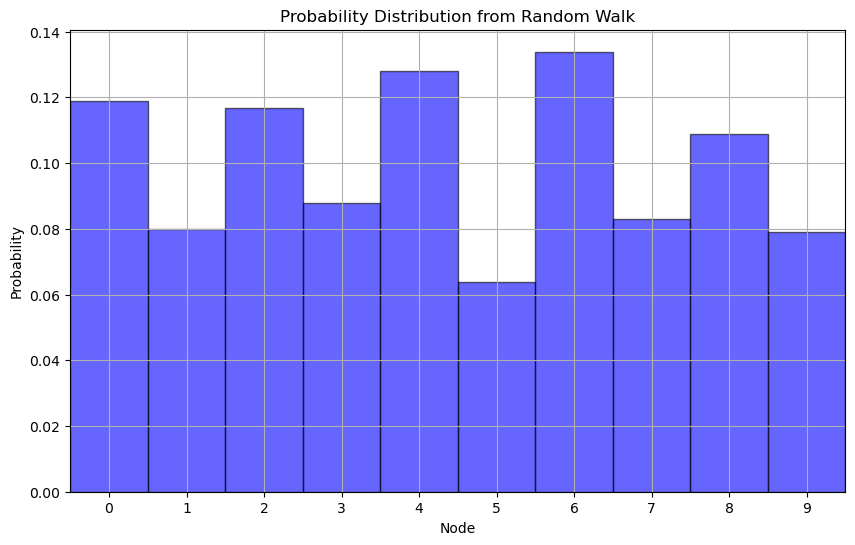

In [22]:
# Simulate a random walk
visited_states = polymer_motion.sample_random_walk(transition_matrix, num_steps)

# Plot the probability distribution of visited states
polymer_motion.plot_probability_distribution(visited_states)

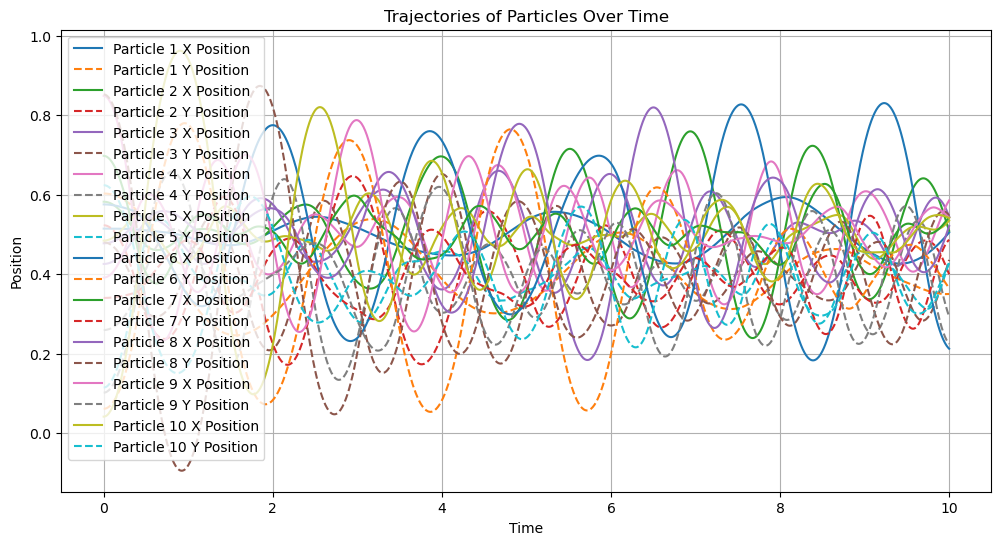

In [24]:
polymer_motion.plot_trajectories()